# 1. What interesting information user can find in the dataset?

### Input data summary

 A. 109 whiskies are described by 5 characteristics: color (14 options),nose (12 options),body (8 options), palate (15 options), finish (19 options).

 B. for each whisky there is distillery assigned. Distillery might be identified by geographical coordinates (latitude/longitude) and region/district (which indicates macrogeographic location, such as proximity to the sea, altiude etc.)

 C. for each whisky there is score indicating quality (varies from 55% to 90%): score is based on one of references invoked in "Lapointe, F.-J. & P. Legendre. 1994. A classification of pure malt Scotch whiskies." study, which is starting point for this study.

D. There is % alcohol data for each scotch, but it's deemed fairly uniform and, more importantly, not really affecting the taste. Therefore column is omitted in this study.

E. There is Age assigned for each scotch. Aging time definitely impacts scotch's taste-related characteristics, but since they are explicitely given in other columns there is no point in analyzing that value (considering taste-related nature of this study).

### Identified potential data applications


 A. relation between whisky quality score and different characteristics: check if whiskies scoring higher are more likely to have certain values of color,nose, body, palate and finish ?

 B. relation between distillery location/district/region and whisky's characteristics: is there any ? (for example, if distilleries of lower altitude tend to produce whisky of certain colour ?)

 C. similarity of whiskies (being analazyed in further part if this study): considering characteristics for each whisky, how "similar" they are to each other ?

# 2. Core code: determine whiskies similarity

###### ASSUMPTION: since questions in the task are related to taste preferences, distillery details (location etc), as well as age and %alcohol are omitted.

### Define function for whisky distance, including only one characteristic

In [11]:
import pandas as pd
from math import *

#EUCLIDEAN DISTANCE: calculates distance between vectors.
def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a,b in zip(x,y)))

#DISTANCE OF ONE WHISKY TO THE ALL OTHER WHISKIES, INCLUDING ONLY ONE CHARACTERISTIC
def char_distance(charFilename,whiskyID):
    df = pd.read_csv(charFilename,delimiter = " ", header = None, skiprows=1)# read data for specified characteristics
    x = df.iloc[whiskyID]#subselect row of interest from full table
    distance = []#empy list
    for idx,row in df.iterrows():# loop over rows
        distance.append(euclidean_distance(x,row))#calculate distance between given row and row of interest
    df = pd.DataFrame(distance)
    return df
char_distance('COLOR.TXT',0) # EXAMPLE: test color similarity of whisky indexed as 1 to all whiskies

,0
0,0.000000
1,1.414214
2,1.414214
3,1.414214
4,1.414214
...,...
104,1.414214
105,1.414214
106,1.414214
107,1.414214


### Define function that will calculate similarity of one whisky to another, including all characteristic.

###### ASSUMPTION: all characteristic are considered to have even weight

In [208]:
def whiskies_distance(charList,whiskyID):
    i=0
    for characteristic in charList:
        if i==0:
            df = pd.DataFrame(char_distance(characteristic,whiskyID))# read/process first characteristic
            i = 1
        else:
            df = df.join(char_distance(characteristic,whiskyID),rsuffix=charList[i]) #read/process further characteristics and append them to dataframe
            i=i+1           
    df.columns=charList # rename columns to match characteristics (indicates used filenames)
    for characteristic in charList:
        df[characteristic] = df[characteristic]/df[characteristic].max()#normalize distance for each characteristic to be 0-1
    df['distance'] = df.mean(axis=1) # after averaging, total distance is average of distances - even weight for all characteristics
    df['name'] = pd.read_csv("NAMES_PSutkowski.txt",header=None) # read whiskies names from custom file
    df['score'] = pd.read_csv("SCORES_PSutkowski.txt",header=None) # read whiskies scores from custom file
    return df
charList = ['COLOR.TXT','NOSE_PSutkowski.TXT','BODY_PSutkowski.TXT','PALATE.TXT','FINISH.TXT'] 

whiskies_distance(charList,77).sort_values(by='distance').head(10) # test
    

,COLOR.TXT,NOSE_PSutkowski.TXT,BODY_PSutkowski.TXT,PALATE.TXT,FINISH.TXT,distance,name,score
77,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Lagavulin,89
103,0.0,0.577350,0.845154,0.707107,0.500000,0.525922,Teaninich,71
87,0.0,0.745356,0.654654,0.790569,0.707107,0.579537,Mortlach,81
101,0.0,0.666667,0.755929,0.790569,0.790569,0.600747,Tamdhu,75
98,1.0,0.577350,0.654654,0.353553,0.612372,0.639586,Longrow,90
88,1.0,0.333333,0.845154,0.612372,0.612372,0.680646,North_Port,64
78,1.0,0.471405,0.654654,0.612372,0.707107,0.689107,Laphroaig,86
12,1.0,0.666667,0.845154,0.612372,0.353553,0.695549,Benrinnes,78
2,1.0,0.333333,0.845154,0.707107,0.612372,0.699593,Ardberg,85
39,1.0,0.666667,0.534522,0.612372,0.790569,0.720826,Glencadam,68


### Dataframe above (that contains distance between WOI and every other whisky)will be used for postprocessing

# 3. Data visualization and further processing

### I' m choosing Lagavulin (ID77) as "whisky of interest" (abbreviated WOI in furhter part of this study)

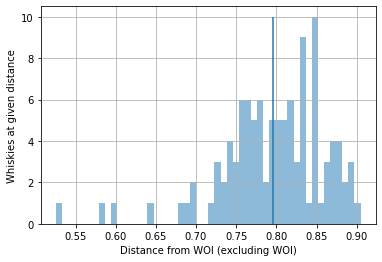

Mean distance of other whiskies from whisky of interest: 0.7961258988590365

Summary of closest whiskies:


,name,distance,score
103,Teaninich,0.525922,71
87,Mortlach,0.579537,81
101,Tamdhu,0.600747,75
98,Longrow,0.639586,90
88,North_Port,0.680646,64
78,Laphroaig,0.689107,86
12,Benrinnes,0.695549,78
2,Ardberg,0.699593,85


In [209]:
import matplotlib.pyplot as plt
WOI = 77 # variable for convenience
df = whiskies_distance(charList,WOI)
df2=df.drop([WOI],axis=0)#exlude WOI because it's obviously at 0 distance from itself
#PLOT HISTOGRAM TO SEE DISTRIBUTION OF DISTANCES
plt.hist(df2['distance'],alpha=0.5,bins=50)
plt.vlines(df2['distance'].mean(),ymin=0,ymax=10)
plt.xlabel('Distance from WOI (excluding WOI)')
plt.ylabel('Whiskies at given distance')
plt.grid(True)
plt.show()

print("Mean distance of other whiskies from whisky of interest: " + str(df2['distance'].mean()))
print("\nSummary of closest whiskies:")
df2.loc[df2['distance']<0.7,['name','distance','score']].sort_values(by='distance') # treshhold of 0.7 applied based on histogram judgement


###### Interim conclusion: distance between whisky of interest (WOI) and other whiskies is 0.80 on average. Judging from distance histogram, distance lower than 0.70 would indicate that whisky tend to be closer than other to WOI Therefore whiskies listed in the table above might be tested first in search of scotch similar to WOI. Testing might be performed at order of similarity (lower distance) or at order of score.

###### Let's see how WOI, "similar" whiskies and "distant" whiskies (divided based on threshold) might be perceived in terms of considered characteristics

### Plot of each whisky in "characteristic distance" - "total distance" plane

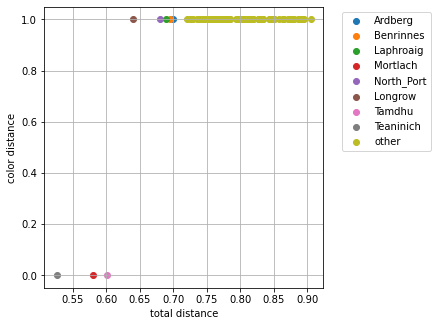

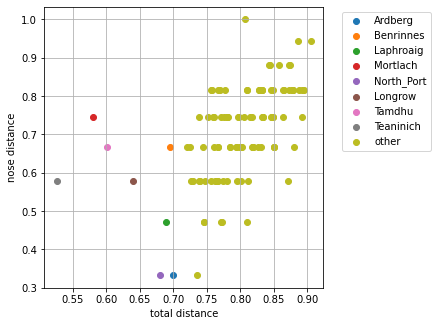

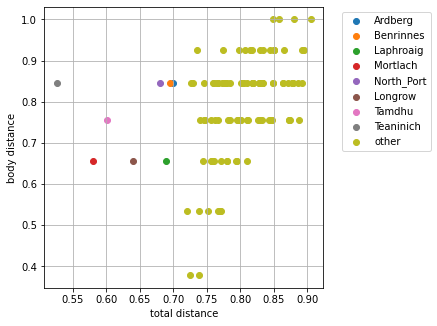

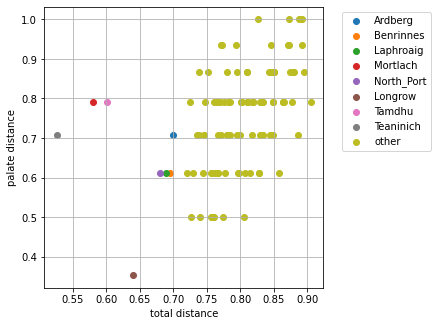

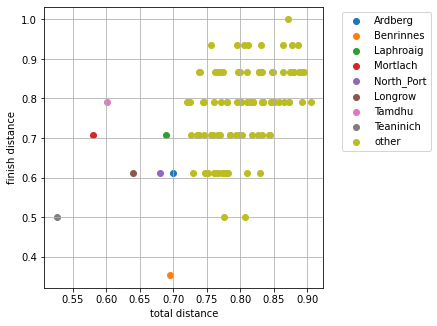

In [210]:
# rename headers in distance dataframe for convenience
df2.columns = ['color','nose','body','palate','finish','distance','name','score'] 
similar = df2.loc[df2['distance']<0.7,:]#0.7 is treshold based on histogram plot
other = df2.loc[df2['distance']>=0.7,:]

#function to faciliate plotting, to make loop over characteristics easier
def plotTaste(data1,data2,label1,label2,xvar,yvar,index,totalPlots,xlabel,ylabel):
    plt.figure(figsize=(5,30))
    plt.subplot(totalPlots,1,index)
    #LOOP OVER EACH ROW OF SIMILAR WHISKIES, TO SEE NAMES AND PROXIMITY
    for idx,row in data1.iterrows():
        plt.scatter(row[xvar],row[yvar],label = row['name'])
    plt.scatter(data2[xvar],data2[yvar],label = label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
      
taste_chars = ['color','nose','body','palate','finish']
index = 1
for taste in taste_chars:
    plotTaste(similar,other,'similar','other','distance',taste,index,len(taste_chars),'total distance', taste + ' distance',)
    index=index+1
    
    ###CLOSER TO BOTTOM LEFT CORNER MEANS THE WHISKY IS CLOSER TO THE WHISKY OF INTEREST

###### Further conclusions

Teaninich is identified to be closest to WOI in terms of "total distance", which accounts for all taste-related characteristics discussed in this study. However due whisky enthusiasts individual preferences, one may consider some characteristics to be more important than the other. Based on above plots, following conclusions are proposed:

If you are enthusiast of Lagavulin whisky and you consider scotch's color to be most important part of drinking experience, you should try, except of already mentioned Teaninich: Mortlach and Tamdchu. 

If you are enthusiast of Lagavulin whisky and you consider scotch's nose to be most important part of drinking experience, you should try North Port and Ardberg.

If you are enthusiast of Lagavulin whisky and you consider scotch's body to be most important part of drinking experience, you should try Mortlach and Longrow.

If you are enthusiast of Lagavulin whisky and you consider scotch's palate to be most important part of drinking experience, you should try Longrow and North Port.

If you are enthusiast of Lagavulin whisky and you consider scotch's finish to be most important part of drinking experience, you should try, except of already mentioned Teaninich: Benrines and Longrow.

# 4. Additional scenario: neglecting color

Till this point, color was considered as a taste-related characteristic. However it might not be the case - in the short analysis below processing will be repeated, but color will be completely excluded from study.

Histogram of whisky distance from whisky of interest


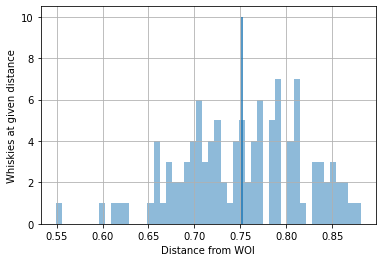

Mean distance of other whiskies from whisky of interest (color neglected): 0.7521018180182403

Summary of closest whiskies (color neglected):


,name,distance,score
98,Longrow,0.549482,90
88,North_Port,0.600808,64
78,Laphroaig,0.611384,86
12,Benrinnes,0.619437,78
2,Ardberg,0.624492,85


In [211]:
#BLOCK 145 is repeated, with char list changed to exclude color. 
import matplotlib.pyplot as plt
WOI = 77 # variable for convenience
charListNC = ['NOSE_PSutkowski.TXT','BODY_PSutkowski.TXT','PALATE.TXT','FINISH.TXT'] 
df5 = whiskies_distance(charListNC,WOI)
df6=df5.drop([WOI],axis=0)#exlude WOI because it's obviously at 0 distance from itself
plt.hist(df6['distance'],alpha=0.5,bins=50)
plt.vlines(df6['distance'].mean(),ymin=0,ymax=10)
plt.xlabel('Distance from WOI')
plt.ylabel('Whiskies at given distance')
plt.grid(True)
print("Histogram of whisky distance from whisky of interest")
plt.show()
print("Mean distance of other whiskies from whisky of interest (color neglected): " + str(df6['distance'].mean()))
print("\nSummary of closest whiskies (color neglected):")
df6.loc[df6['distance']<0.65,['name','distance','score']].sort_values(by='distance') # new treshhold is applied


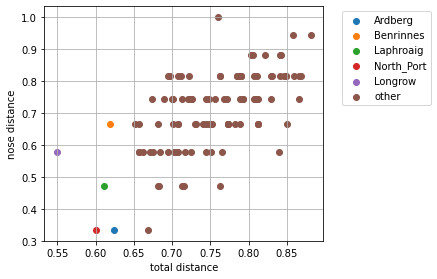

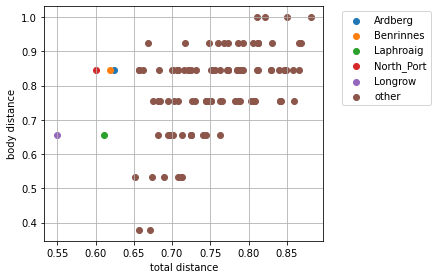

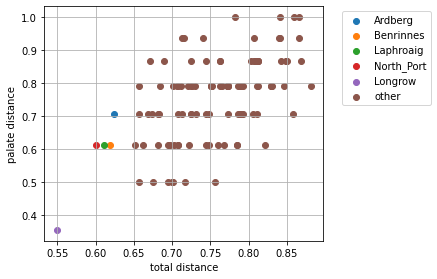

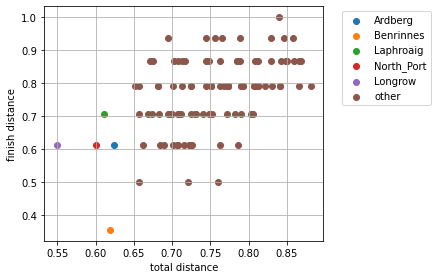

In [205]:
#BLOCK 162 is repeated, with char list changed to exclude color. Variable names changed just in case
df6.columns = ['nose','body','palate','finish','distance','name','score'] 
similarNC = df6.loc[df6['distance']<0.65,:]
otherNC = df6.loc[df6['distance']>=0.65,:]

def plotTaste(data1,data2,label1,label2,xvar,yvar,index,totalPlots,xlabel,ylabel):
    plt.figure(figsize=(5,25))
    plt.subplot(totalPlots,1,index)
    for idx,row in data1.iterrows():
        plt.scatter(row[xvar],row[yvar],label = row['name'])
    plt.scatter(data2[xvar],data2[yvar],label = label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
      
taste_charsNC = ['nose','body','palate','finish']
index = 1
for taste in taste_charsNC:
    plotTaste(similarNC,otherNC,'similar','other','distance',taste,index,len(taste_chars),'total distance', taste + ' distance',)
    index=index+1

###### Conclusions from alternate scenario (neglecting color characteristic)

Distances between WOI and other whiskies have changed. With such approach, Longrow becames closest one to the WOI in terms of total distance. Similarly to what was concluded previously, following conclusions are drawn.

If you are enthusiast of Lagavulin whisky and you consider scotch's nose to be most important part of drinking experience, you should try North Port and Ardberg.

If you are enthusiast of Lagavulin whisky and you consider scotch's body to be most important part of drinking experience, you should try previously mentioned Longrow and Laphroaig.

If you are enthusiast of Lagavulin whisky and you consider scotch's palate to be most important part of drinking experience, you should try, except from previously mentioned Longrow: North Port, Laprhroaig and Benrinnes.

If you are enthusiast of Lagavulin whisky and you consider scotch's finish to be most important part of drinking experience, you should try, except of already mentioned Longrow: Benrinnes, Ardberg and North_Port.

# 5. Summary and conclusion (finish of 1st, 24h attempt)

This study is a part of recruitment process for Data Analyst position at Schneider Electric company.

Dataset about scotch whiskies (available from "Lapointe, F.-J. & P. Legendre. 1994. A classification of pure malt Scotch whiskies.") was analyzed in this study.

Lagavulin whisky was chosen arbitrary as a "starting point", according to given task - study compares other whiskies to chosen one.

Main focus of the analysis was on determining method for calculating whiskies similarity: given set of characteristics (color, taste, nose, palate, finish) euclidean distance was calculated between Lagavulin whisky and all other whiskies in the dataset - distance was calculated separately for each characteristic. Then, results were normalized and averaged to calculate "total" distance between two whiskies, assuming all  characteristics have the same importance (weight).

With approach described above, Teaninich was identified as closest to the Lagavulin. Additionally, short "guide" to selecting whisky closest to Lagavulin was written, for those who strongly prefer one of whisky's characteristcS over the other.

Study was repeated with assumption that scoth's color does not affect drinking experience (color variable was excluded from the study). Result were presented in the same form as for study considering all characteristics.

# 6. Follow up: Hierarchical clustering

Based on https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

###### Read data and make sure it's normalized

In [42]:
import pandas as pd
whiskyDF=pd.read_csv("SCOTCH_PSutkowski.txt",sep="\t",index_col=0)
tasteDF=whiskyDF.iloc[:,:-1] #disregard last column, it's a score - not needed for clustering
tasteDF.describe()

,c_wyne,c_yellow,c_v.pale,c_pale,c_p.gold,c_gold,c_o.gold,c_f.gold,c_bronze,c_p.amber,...,F_smoke,F_sweet,F_spice,F_oil,F_salt,F_arome,F_ling,F_long,F_very,F_quick
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,...,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,0.073394,0.018349,0.018349,0.036697,0.091743,0.192661,0.018349,0.247706,0.045872,0.036697,...,0.192661,0.165138,0.128440,0.055046,0.073394,0.064220,0.100917,0.220183,0.036697,0.055046
std,0.261987,0.134829,0.134829,0.188886,0.289996,0.396210,0.134829,0.433674,0.210173,0.188886,...,0.396210,0.373020,0.336125,0.229123,0.261987,0.246277,0.302611,0.416284,0.188886,0.229123
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### Data looks good, plot a dendrogram usign scipy.cluster.hierarchy, as described in the example referenced in the beginning

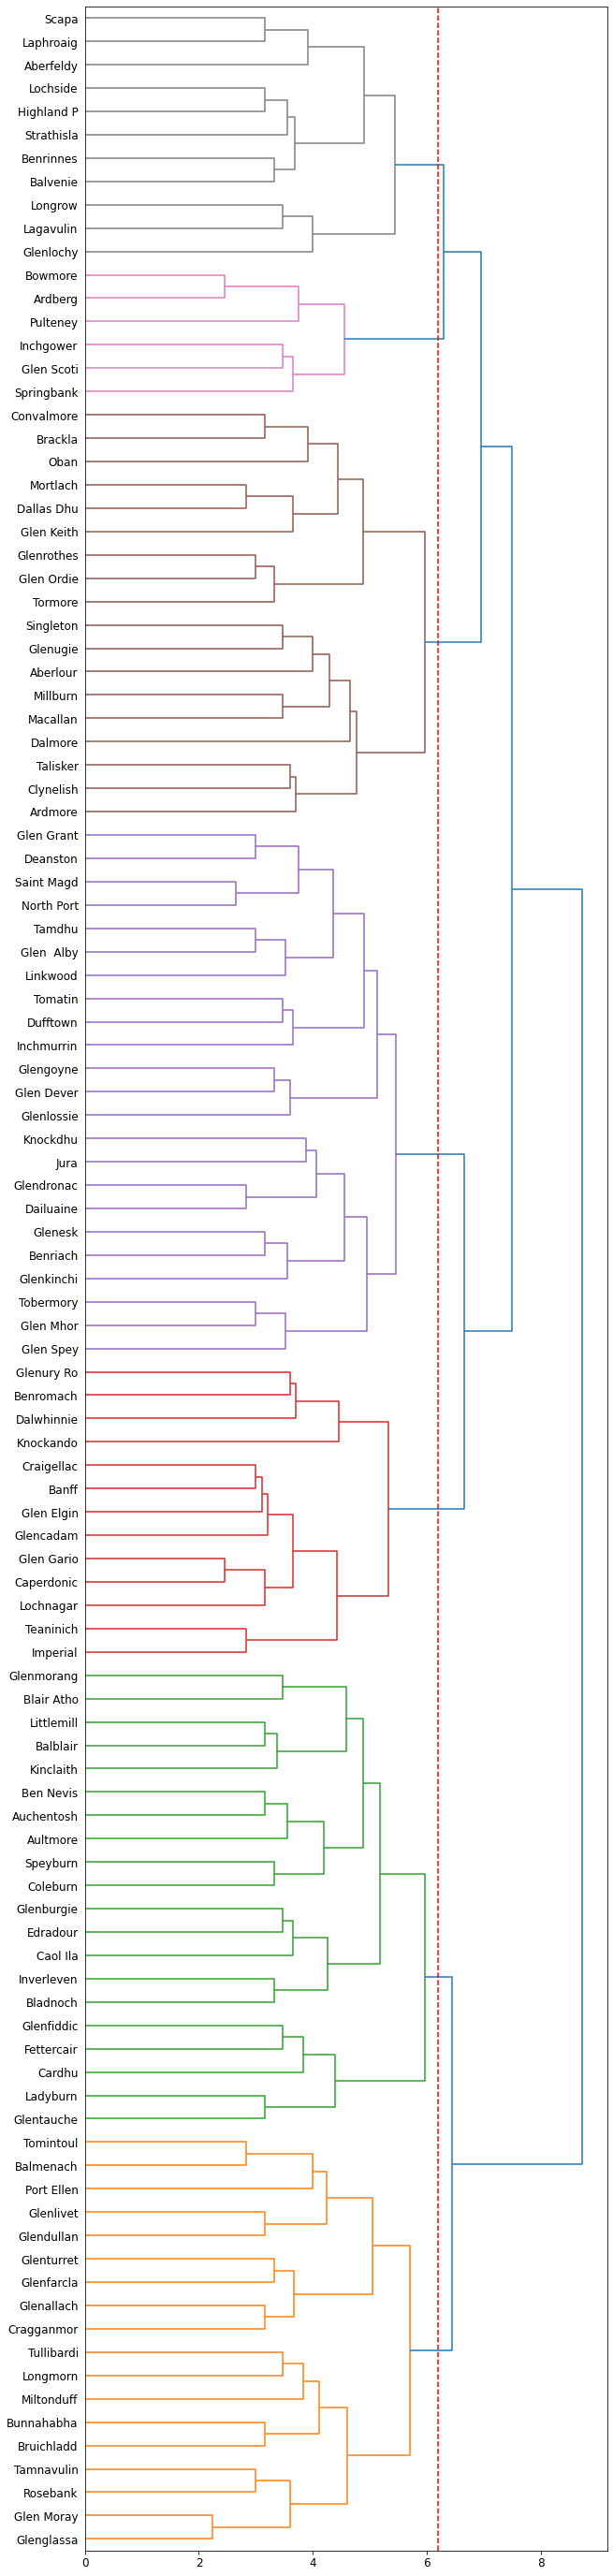

In [30]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 50))  
#plot dendrogram
dend = shc.dendrogram(shc.linkage(tasteDF,metric='euclidean',method='ward'),orientation='right',labels = tasteDF.index.values )
#change font size
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)
#plot line. 7 clusters seems like good first try <= distance treshhold of 6.2 applied to accordingly. 
plt.axvline(x=6.2, color='r', linestyle='--')

###### Append cluster number as a column to the dataframe with all whiskies. 

In [44]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
tasteDF['cluster'] = cluster.fit_predict(tasteDF)
#COLUMN APPENDED, NOW TEST IF RESULTS CONSISTENT WITH DENDROGRAM ABOVE (IT'S DIFFERENT LIBRARY AFTER ALL)
clusterID = tasteDF.loc['Lagavulin']['cluster']
print(tasteDF.loc[tasteDF['cluster']==clusterID]['cluster'])
print(tasteDF.loc[tasteDF['cluster']==clusterID]['cluster'].shape)
# COUPLE SETS TESTED - RESULTS CONSISTENT !

Aberfeldy     2
Balvenie      2
Benrinnes     2
Glenlochy     2
Highland P    2
Lagavulin     2
Laphroaig     2
Lochside      2
Scapa         2
Longrow       2
Strathisla    2
Name: cluster, dtype: int64
(11,)


###### Results obtained from sklearn.cluster and scipy.cluster.hierarchy are consistent (as checked by comparison of sinppet results above and dendrogram)

###### Important comment

Cluster that contains Lagavullin whisky (one discussed in paragraphs 1-5) looks somewhat different that closest whiskies identified in the first part (Out 209 block). It might be caused by 2 things:

First is that distance is calculated in slightly different manner - initialy, each of 5 main characteristics was treated separatly and distance was averaged. As a result similarity in color was as important as similarity in finish etc. Now, euclidean distance is calculated between two whole vectors of characteristics - therefore if there are more types of finish than types of body, finish will contribute more to the euclidean distance than the body. This can be resolved by proper weighting of input data.

Second is clustering alghorithm. At the beginning, each whisky is considered separate cluster. Process starts with 2 closest clusters and cluster them together. Distance matrix is updated and process is continued till there is only one cluster. So it's possible, that if 2 whiskies are quite close to each other, but somewhere else there are even closer whiskies, two relatively close whiskies will end up in different clusters. This can be adjusted for example by setting different desired number of clusters or changing alghoritm from Agglomerative to Divisive.

That being said, let's see if treating each column equally (disregarding five major characteristic groups, as it is done on the input to clustering alghorithm) causes significant difference compared to original approach.

In [46]:
testDF = tasteDF.iloc[:,:-2]
distance = []
x=testDF.iloc[77]
for idx,row in testDF.iterrows():# loop over rows
    distance.append(euclidean_distance(x,row))#calculate distance between given row and row of interest
testDF.loc[:,'distance'] = distance
testDF.loc[:,'distance'] = testDF.loc[:,'distance']/testDF.loc[:,'distance'].max() # normalize distance
testDF.sort_values(by='distance').loc[:,'distance'].head(10)

Lagavulin     0.000000
Longrow       0.666667
Laphroaig     0.720082
North Port    0.720082
Teaninich     0.720082
Benrinnes     0.745356
Glenlochy     0.745356
Ardberg       0.745356
Bowmore       0.769800
Glencadam     0.769800
Name: distance, dtype: float64

Table listing distances of 9 whiskies closest to Lagavulin shows slightly different values than in Out [208] block, but 7 names are repeated which indicates reasonable consistency. Due to qualititave nature of this task, those differences will be disregarded and in further assessments distance between whiskies will be caluclated as Euclidean, considering each column separately.

# 7. Follow up: Exploratory data analysis

###### Calculate and visualize distance matrix

<AxesSubplot:>

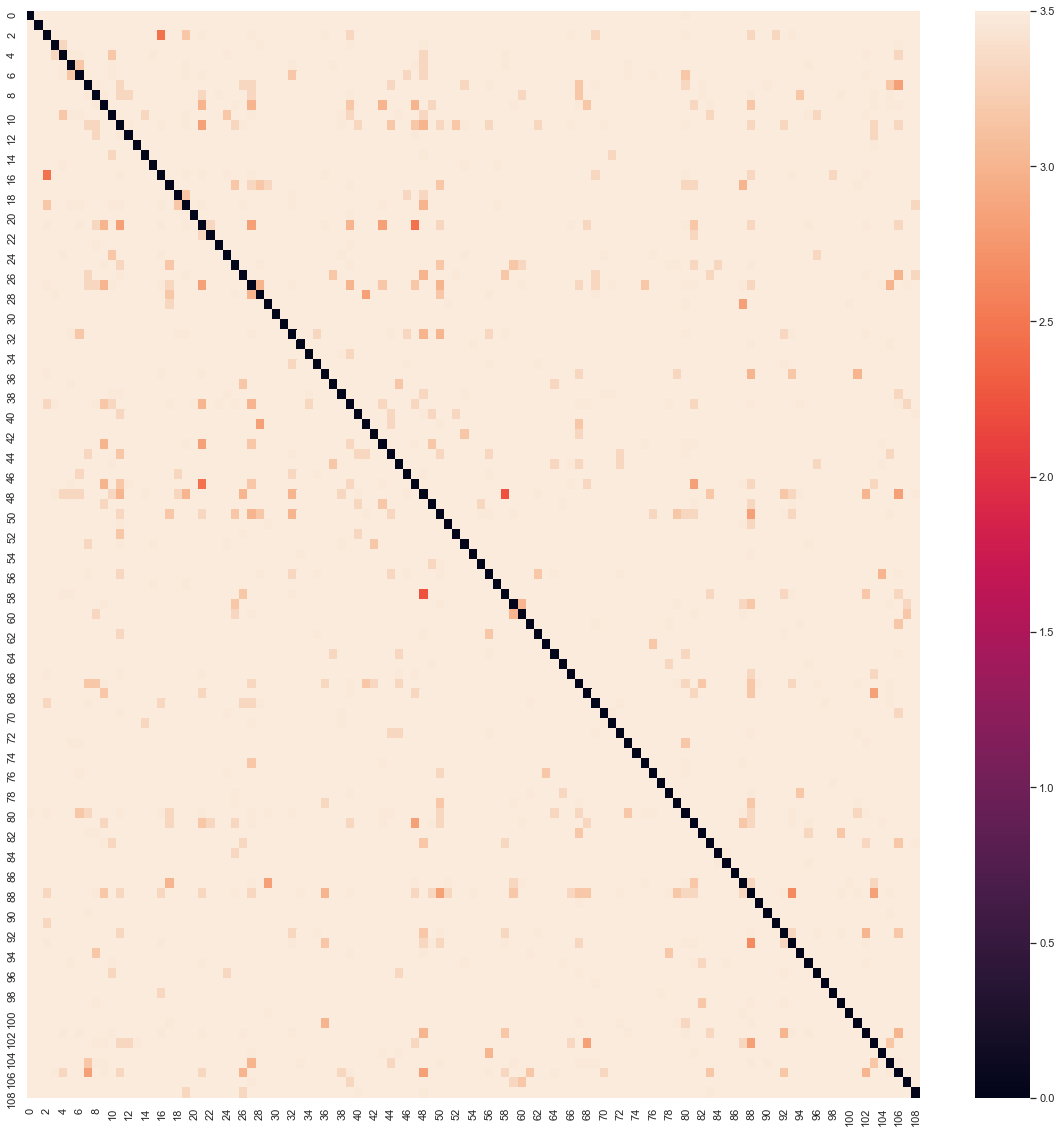

In [105]:
#REREAD DATA JUST IN CASE
whiskyDF=pd.read_csv("SCOTCH_PSutkowski.txt",sep="\t",index_col=0)
tasteDF=whiskyDF.iloc[:,:-1] #disregard last column, it's a score - not needed for clustering

# FUNCTION THAT RETURNS DISTANCE MATRIX

def distanceMatrix(df):
    distMatrix = pd.DataFrame(0, index=range(len(df.index)),columns=range(1))
    #distMatrix = pd.DataFrame()
    for i,row in df.iterrows():
        dist = []
        for j,row2 in df.iterrows():
            dist.append(euclidean_distance(row,row2))
        df_dist = pd.DataFrame(dist)
        distMatrix = distMatrix.join(df_dist,rsuffix='_')
    distMatrix=distMatrix.iloc[:,1:]
    distMatrix.columns = range(len(df.index))
    return distMatrix
DM = distanceMatrix(tasteDF)

import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(DM,vmin=0,vmax=3.5)

            

In [52]:
whiskyDF=pd.read_csv("SCOTCH_PSutkowski.txt",sep="\t",index_col=0)# read data again just in case
whiskyDF.loc[:,'cluster'] = tasteDF.loc[:,'cluster']# append data about clusters to whiskyData
whiskyDF.head()



,c_wyne,c_yellow,c_v.pale,c_pale,c_p.gold,c_gold,c_o.gold,c_f.gold,c_bronze,c_p.amber,...,F_spice,F_oil,F_salt,F_arome,F_ling,F_long,F_very,F_quick,SCORE,cluster
Aberfeldy,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,69,2
Aberlour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,83,0
Ardberg,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,85,6
Ardmore,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,66,0
Auchentosh,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,85,1
